In [27]:
from pprint import pprint
from matplotlib import pyplot as plot
from gitminer import (
    graph_commit_to_file,
    graph_file_to_file,
    print_most_connected,
    print_most_common_commits,
    count_commits,
    count_connections
)
from git import Repo
from collections import Counter
import networkx as nx
from itertools import combinations

In [28]:
repo = Repo("quizzology")

In [29]:
little_labels = dict(with_labels=True, font_size=7)
medium_labels = dict(with_labels=True, font_size=7)

In [30]:
repo_graph = graph_file_to_file(repo)

# Neighbors
## Who are the top 10 most-connected nodes?

This is basically handed to us by the degree accessor, which gives us the file and its number of edges.


In [31]:
print_most_connected(repo_graph)

Top ten most connected files
main.py 128
features/steps/BasicQuizOperations.py 93
quizzes/quiz.py 67
quizzes/question.py 63
tests/test_quiz_rendering.py 62
quizzes/quiz_store.py 60
tests/test_quiz_session.py 60
ui_tests/test_navigation.py 59
quiz_content/cats.json 57
tests/test_quiz_selection.py 57


# Top 20

What are the top 20 most-changed files? We used to get this with a complicated git/sort/uniq script. Here it's much easier.

In [32]:
commit_graph = graph_commit_to_file(repo)

In [33]:
print_most_common_commits(commit_graph)


Most commits (top 10):
main.py: 240
features/steps/BasicQuizOperations.py: 73
test_quiz_session.py: 37
ui_tests/test_navigation.py: 32
test_quiz_selection.py: 32
features/steps/authenticate_user.py: 31
quizzes/quiz_store.py: 30
quizzology.py: 30
test_quiz_rendering.py: 30
ui_tests/test_base_url.py: 29


# Create a plot 

x = [5, 2, 9, 4, 7]
y = [10, 5, 8, 4, 2]
plot.plot(x, y)
plot.show()

# Draw a network plot of some kind

graph = nx.petersen_graph()  # well known sample data
subax = plot.subplot(121)
nx.draw(graph)

repo_plot = plot.subplot(122)
nx.draw(repo_graph, **little_labels)



help(nx.draw)


In [34]:
# This produces three lists - when we look at the whole repo, everything
# is connected except some images. This is reasonable given the entire
# history of a small project. We need to try this time-limited.
pprint(list(nx.connected_components(repo_graph)))


[{'.dockerignore',
  '.github/workflows/quizzology-ci.yml',
  '.gitignore',
  '.pre-commit-config.yaml',
  '.pylintrc',
  'Dockerfile',
  'README.md',
  'TestDockerfile',
  'apps/__init__.py',
  'apps/author.py',
  'apps/author/__init__.py',
  'apps/author/author.py',
  'apps/author/author_controller.py',
  'apps/author/tests/__init__.py',
  'apps/author/tests/test_authorcontroller.py',
  'apps/author/tests/test_controller.py',
  'apps/author/tests/test_quiz_authoring_form.py',
  'apps/author/tests/test_quiz_schema.py',
  'apps/author/views/quiz_author_home.tpl',
  'apps/author/views/quiz_authoring_form.tpl',
  'apps/authoring/__init__.py',
  'apps/authoring/author.py',
  'apps/authoring/views/quiz_authoring_form.tpl',
  'apps/study.py',
  'apps/study/__init__.py',
  'apps/study/session_store.py',
  'apps/study/session_store_mongodb.py',
  'apps/study/session_store_tinydb.py',
  'apps/study/study.py',
  'apps/study/studycontroller.py',
  'apps/study/tests/__init__.py',
  'apps/study/te

In [35]:
# Perhaps we should trim the data set so that we don't plot every single 
# edge and node in one ugly graph.

# Here we limit the data set only to edges that have been connected 
# at most 12 times (that's 1/10th of the busiest from the prior run)
one_tenth_of_busiest = 12
busiest_graph = nx.Graph()
busiest_graph.add_edges_from(
    edge
    for edge in repo_graph.edges
    if repo_graph.get_edge_data(*edge).get('count', 0) > one_tenth_of_busiest
)


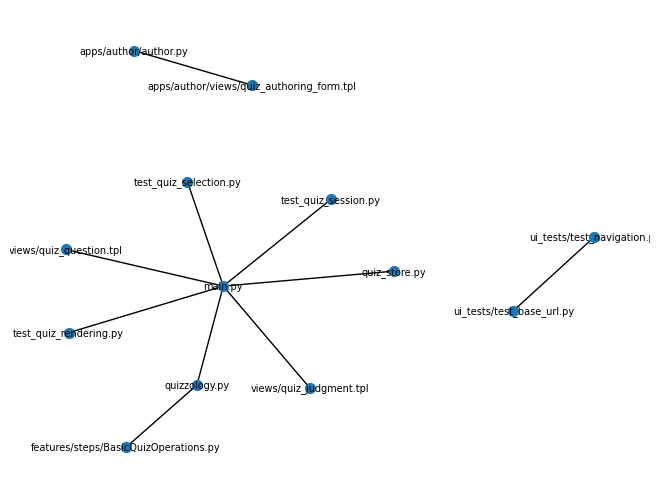

In [36]:
# Here we try graphing this smaller set...
from networkx import spring_layout

layout = spring_layout(busiest_graph, k=0.8, iterations=50)
nx.draw(busiest_graph, layout, **little_labels, node_size=50)

# As expected, "main.py" is the spider at the center of the web. 
# There are some other connections such as between forms and the data
# they display or gherkin tests and the module they are testing.

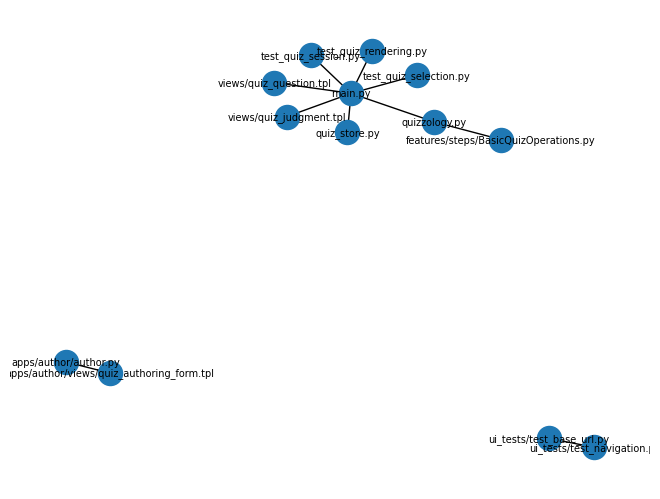

In [37]:
# nx.draw_random(busiest_graph, **little_labels)
nx.draw_spring(busiest_graph, **little_labels)
# Same data, different visualization algo...

# Concept

If we combine *most committed*, and *most connected*, and some *complexity* measure, then we should end up with a basis for a ranked "refactoring candidate" list. 

## Hypothesis: TARGET SELECTION
Imagine pointing a tool at a codebase, and it tells you where to concentrate your efforts on code renewal, and maybe you re-run it monthly or weekly? Would this make a significant difference in fluidity, fluency, speed, and quality? 

## Notes

- This needs to be time-limited, or it will be based on all-time, not recent activity.
- When you first rework a file, it will still show up in the list
- Maybe when we refactor a file, it can drop it out of the candidate list. If it is still a problem, it will reappear later, when that refactoring commit "ages out."
- if this only works with "conventional commits," that's probably okay. We could also support Belshee's cryptic commit trickery.


In [38]:
commit_dict = dict(count_commits(commit_graph))
connect_dict = dict(count_connections(repo_graph))
for file in commit_dict.keys():
    print(f' {file}, {commit_dict[file]}  commits, {connect_dict.get(file, 0)} relations')

 main.py, 240  commits, 128 relations
 webdrivers/darwin/chromedriver, 9  commits, 4 relations
 precommit.md, 2  commits, 3 relations
 .pre-commit-config.yaml, 3  commits, 5 relations
 devtools.txt, 13  commits, 11 relations
 test_delme.py, 2  commits, 3 relations
 runtests, 1  commits, 1 relations
 session_scratch.py, 3  commits, 31 relations
 ui_tests/test_base_url.py, 29  commits, 54 relations
 apps/study/tests/test_quiz_question.py, 3  commits, 28 relations
 README.md, 13  commits, 32 relations
 apps/study/session_store_mongodb.py, 9  commits, 16 relations
 apps/study/tests/test_session_store_mongo.py, 3  commits, 2 relations
 sessions/tests/test_quiz_session_store.py, 9  commits, 34 relations
 sessions/tests/test_quiz_session_store_tinydb.py, 1  commits, 2 relations
 apps/study/session_store.py, 8  commits, 18 relations
 apps/study/session_store_tinydb.py, 6  commits, 18 relations
 apps/study/study.py, 14  commits, 52 relations
 apps/study/tests/test_routes.py, 8  commits, 25 rela

Interesting ideas
* Average commit size
* Tests included in commits?
* Connected groups
* Most edited files
* Commit frequency
* Defects vs Features vs Refactors vs Other (conventional commits?)
* Ticket numbers and clustering of same

In [39]:
# Average commit size
repo = Repo('quizzology')
commits = [(commit.author.name, commit.authored_datetime, len(commit.stats.files))
           for commit
           in repo.iter_commits()
           ]
pprint(commits[:3])

[('Tim Ottinger',
  datetime.datetime(2023, 6, 13, 8, 17, 56, tzinfo=<git.objects.util.tzoffset object at 0x16e9b9510>),
  1),
 ('Perry Reid',
  datetime.datetime(2023, 6, 13, 10, 0, 18, tzinfo=<git.objects.util.tzoffset object at 0x16e853f50>),
  1),
 ('Tim Ottinger',
  datetime.datetime(2023, 6, 12, 16, 9, 43, tzinfo=<git.objects.util.tzoffset object at 0x16e54bd50>),
  1)]


In [40]:
# How to break into separate components? 

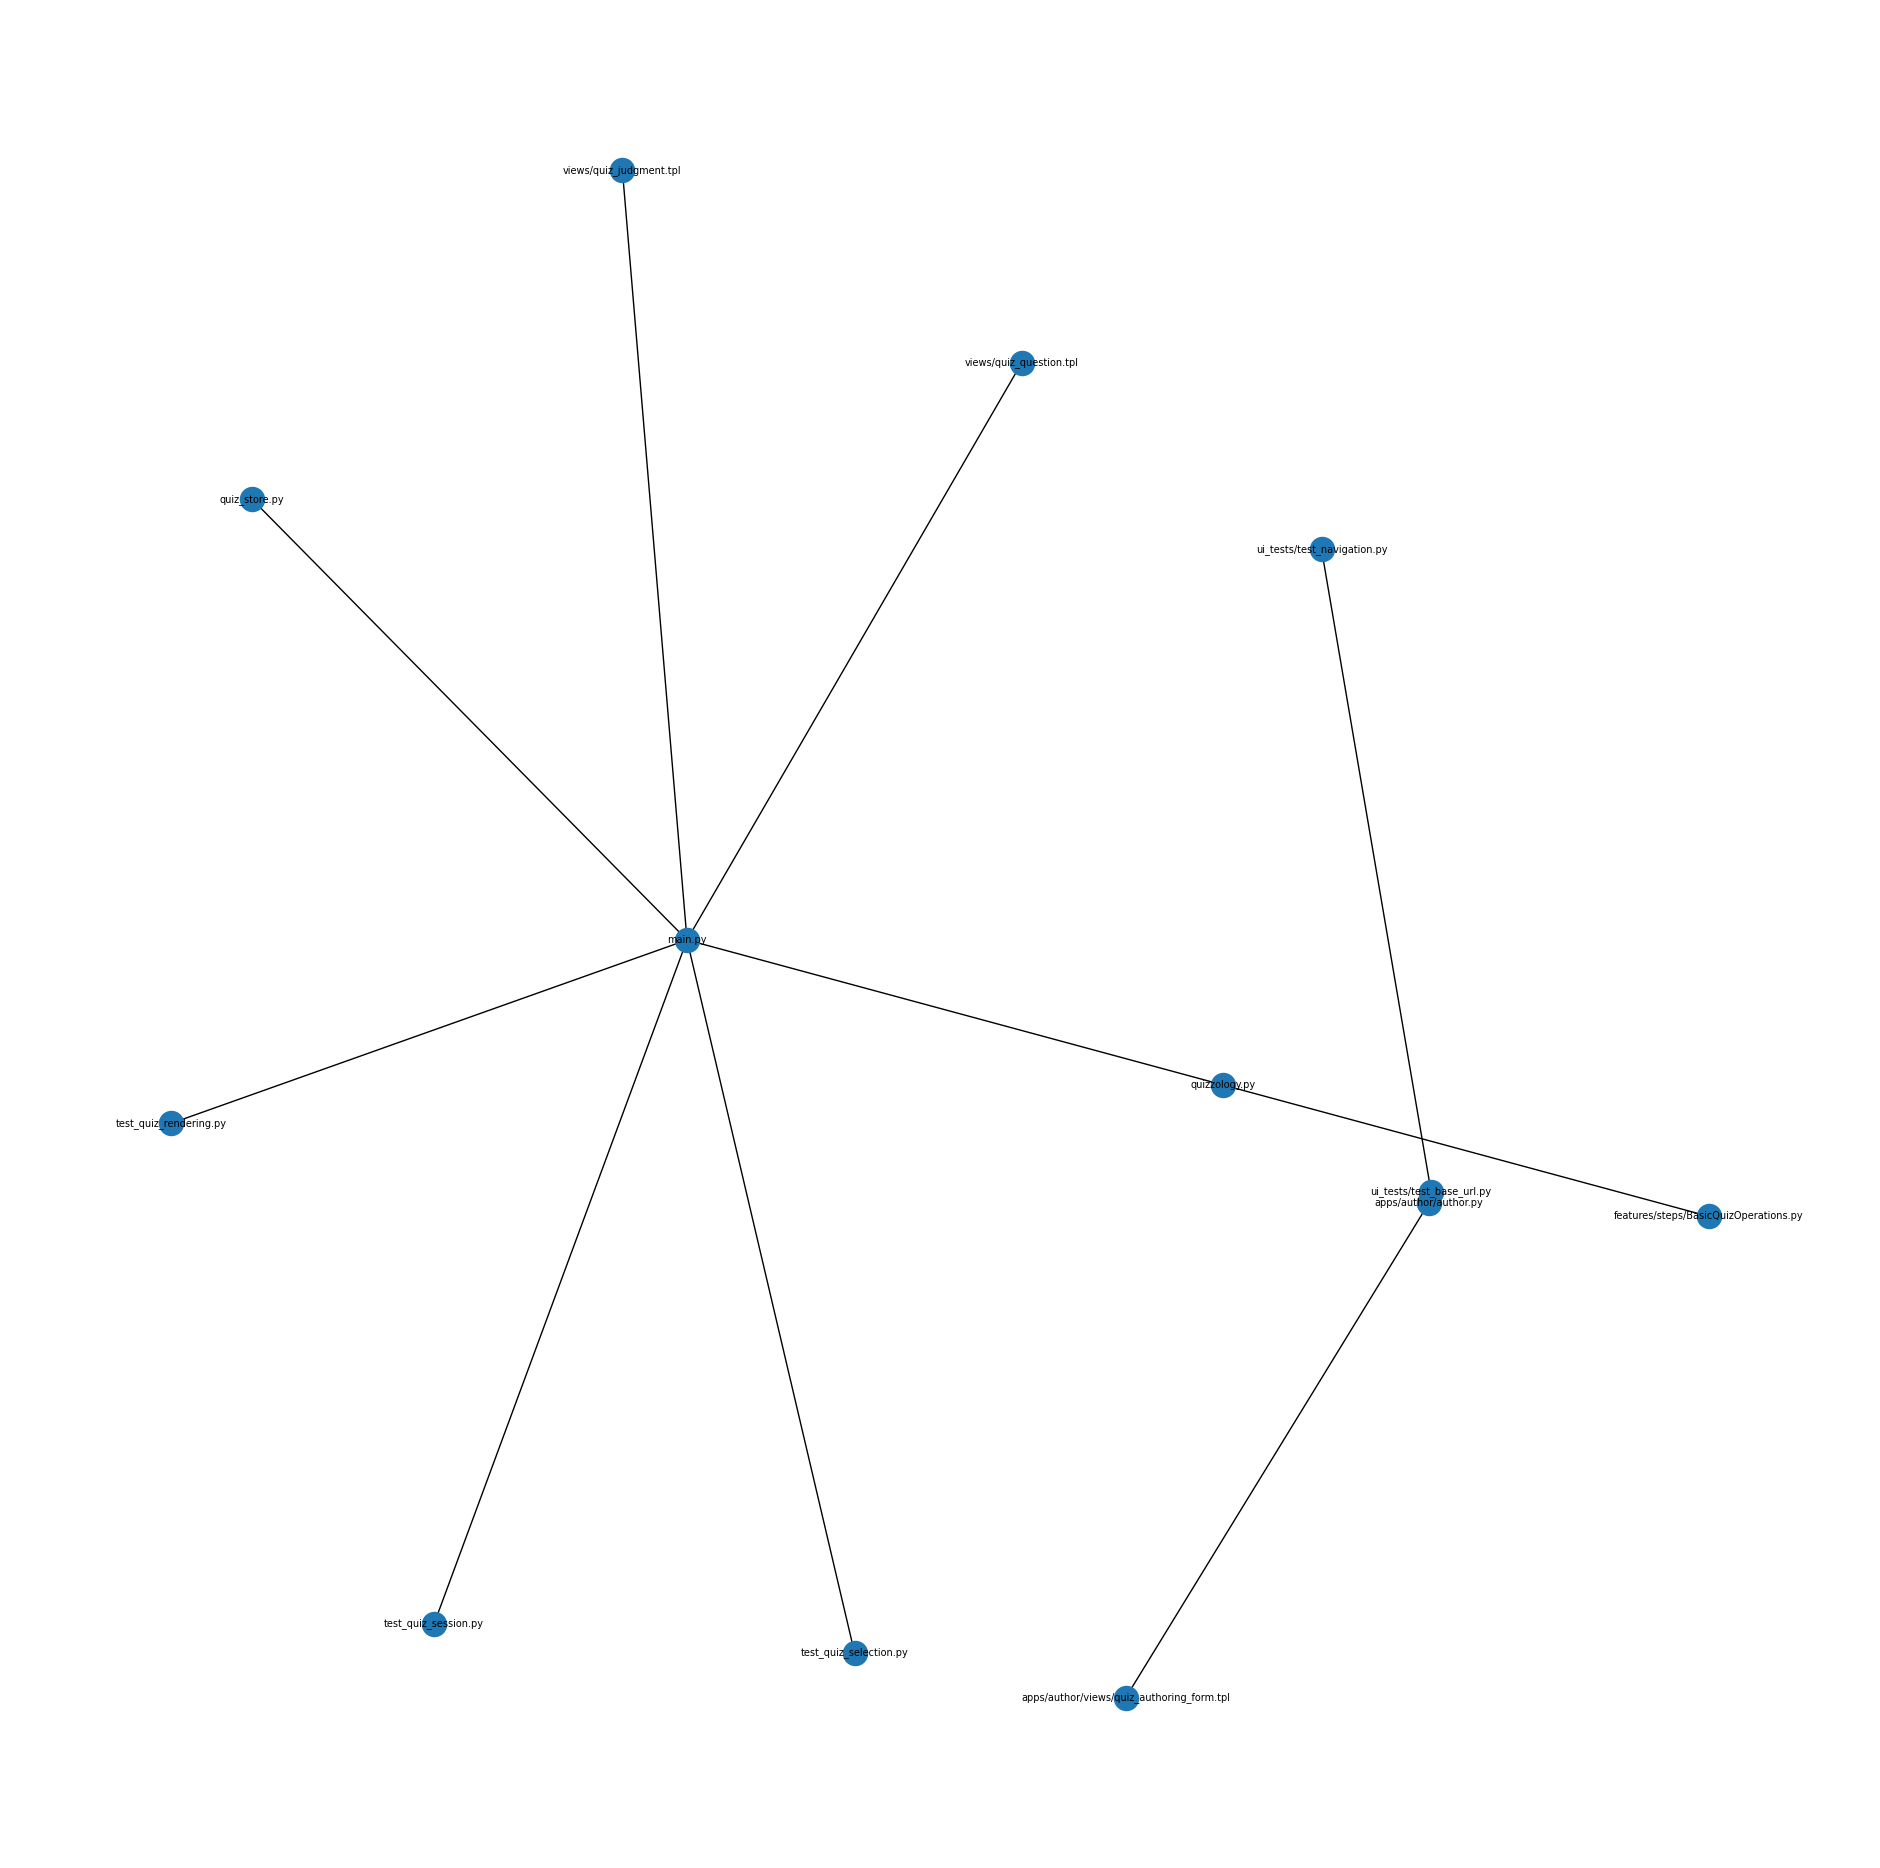

In [41]:
fig, ax = plot.subplots(figsize=(24, 24))
nx.draw_kamada_kawai(busiest_graph, **medium_labels)

In [42]:
#What if we remove the most heavily connected items instead of the least-heavily?


In [43]:
from statistics import mean, stdev, variance, multimode


def print_stats(file_counts):
    print(f'  Largest commit is {max(file_counts)} files')
    print(f'  Average commit is {mean(file_counts)} files')
    print(f'  Standard Deviation is {stdev(file_counts)}')
    print(f'  Variance is {variance(file_counts)}')
    print(f'  Multimode is {multimode(file_counts)}')

In [44]:
print("FULL repository Data Set")
print_stats([x for (_, _, x) in commits])

FULL repository Data Set
  Largest commit is 30 files
  Average commit is 2.30484693877551 files
  Standard Deviation is 2.2111240825297678
  Variance is 4.889069708343107
  Multimode is [1]


In [45]:
# Maybe a multigraph is wise?
repo = Repo("quizzology")
repo_multigraph = nx.MultiGraph()
for commit in repo.iter_commits():
    for (left, right) in combinations(commit.stats.files, 2):
        repo_multigraph.add_edge(left, right)

# Activity Graph Concept
A graph of the number of commits per day might be useful - a stacked bar graph if you can tell what kinds of commits.
I imagine coloring the stack by 'conventional commit' topics: fixes on bottom, then feature, then whatever else.
'Commit Cadence'

Can we discern the kinds of commits we're looking at via ticket names, conventional commits, or Belshee commits?

Can we eliminate trivial commits (less than one line of change, less than 10 characters, etc.)?

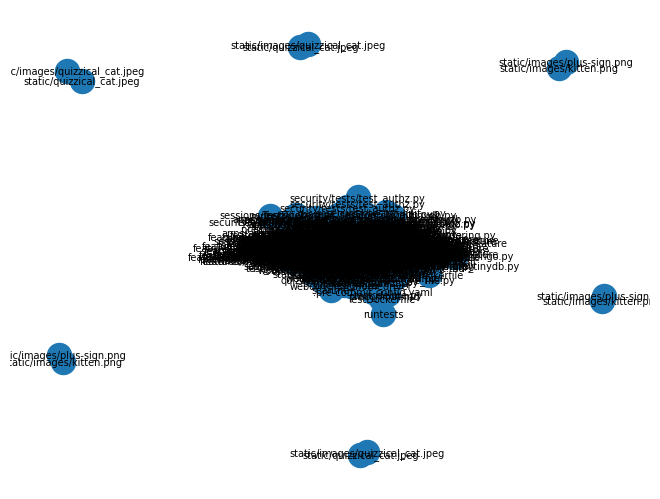

In [46]:
# This is probably the wrong visualization. 
for topic in nx.connected_components(repo_multigraph):
    nx.draw(repo_multigraph, **little_labels)
    # Kittens appear more than once, as do quizzical cats. I think this provides too much info.

In [47]:
from datetime import datetime, timedelta


def within_dates(start_date: datetime, end_date: datetime):
    return [count
            for (_, timestamp, count) in commits
            if start_date <= timestamp.date() <= end_date
            ]


end_date = datetime.today().astimezone().date()
start_date = end_date - timedelta(days=400)
print(f'From {start_date} to {end_date}')

dataset = within_dates(start_date, end_date)
print(f'commits: {len(dataset)}')
print_stats(dataset)

From 2022-07-14 to 2023-08-18
commits: 52
  Largest commit is 14 files
  Average commit is 2.423076923076923 files
  Standard Deviation is 2.12682358981701
  Variance is 4.5233785822021115
  Multimode is [1]


# Rolling graph of just the past N days

Use the timestamp from the repo_graph to filter down the commits

Graph the commits as of a certain day, with a window of N days prior
Graph repeatedly, show maybe bar graphs and such? 



# Drill down Notes

It seems that we could produce a heatmap as a treemap, with drill-down.

* At the top it would have perhaps the connected components.
* Under that, the directories.
* Under directories, the files.
* Under a file, the file's strongest associations
* Under each association, a list of the commits (hash & message)
* Under the list item, a diff from git.


In [48]:
# New focus:
# given file 'main.py'
given='main.py'
